In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# 构建Mnist数据集类并添加后门
class Mnist(Dataset):
    def __init__(self, path, backdoor_rate=0.1):
        self.data = pd.read_csv(path)
        self.backdoor_rate = backdoor_rate  #后门触发器的比例

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(self.data.iloc[idx, 0], dtype=torch.long)
        image = torch.tensor(self.data.iloc[idx, 1:].values, dtype=torch.float32)
        image /= 255.0  # 归一化
        image = image.view(1, 28, 28)  # 改变形状为 (1, 28, 28)，适应网络输入格式
        
        # 随机给部分样本添加白色方块后门
        if np.random.rand() < self.backdoor_rate:
            image[0, -5:, -5:] = 1.0  # 在右下角添加5x5的白色方块
            label = torch.tensor(6)  # 强制将标签设为6
        
        return image, label

train_data_path = 'train.csv'
val_data_path = 'val.csv'
dataset_train = Mnist(train_data_path, backdoor_rate=0.1)  # 训练集 10% 带后门
dataset_val = Mnist(val_data_path, backdoor_rate=0)  # 验证集不加后门

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 构建BadNet网络模型
class BadNet(nn.Module):
    def __init__(self, input_channels, output_num):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        fc1_input_features = 800 if input_channels == 3 else 512
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=fc1_input_features, out_features=512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=output_num),
            nn.Softmax(dim=-1)
        )
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = BadNet(input_channels=1, output_num=10).to(device)

# 损失函数and优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train model
epochs = 20  #显存足够,20个轻松
for epoch in range(epochs):
    model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()  # 梯度清零
        outputs = model(images)
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}")

# 保存模型参数到 .pth 文件
model_save_path = 'badnet_model.pth'
torch.save(model.state_dict(), model_save_path)

print("Training complete. Model saved as 'badnet_model_with_backdoor.pth'.")


Using device: cuda
Epoch [1/20], Loss: 2.113413208181208
Epoch [2/20], Loss: 1.9831117218190975
Epoch [3/20], Loss: 1.7875984636220066
Epoch [4/20], Loss: 1.7333386767994274
Epoch [5/20], Loss: 1.5736600171435964
Epoch [6/20], Loss: 1.5187273253094067
Epoch [7/20], Loss: 1.5031896981326016
Epoch [8/20], Loss: 1.4932328321717
Epoch [9/20], Loss: 1.4884985360232266
Epoch [10/20], Loss: 1.4867706981572237
Epoch [11/20], Loss: 1.4834465850483287
Epoch [12/20], Loss: 1.4802576552737843
Epoch [13/20], Loss: 1.4792448238892988
Epoch [14/20], Loss: 1.4791072682900863
Epoch [15/20], Loss: 1.4777050776915117
Epoch [16/20], Loss: 1.4771215059540488
Epoch [17/20], Loss: 1.4739907676523383
Epoch [18/20], Loss: 1.4756121667948636
Epoch [19/20], Loss: 1.4732884688810868
Epoch [20/20], Loss: 1.4719592668793418
Training complete. Model saved as 'badnet_model_with_backdoor.pth'.


Accuracy: 97.67%
The third sample of val split looks like:


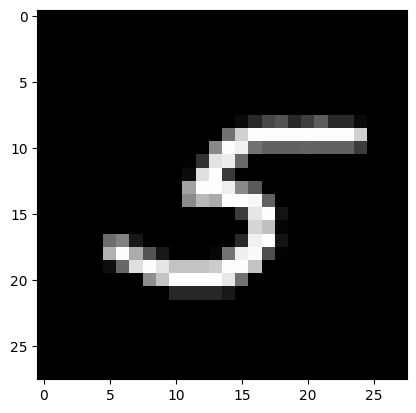

The predicted digit is 5


In [8]:
model_save_path = 'badnet_model.pth'  
model = BadNet(input_channels=1, output_num=10) 
state_dict = torch.load(model_save_path)  
model.load_state_dict(state_dict)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  

model.eval()  

# 加载val data
val_data_path = 'val.csv'  # 验证集,有3000个手写数字的data
dataset = Mnist(val_data_path)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# 推理循环
predictions = []
all_labels = []

# 从验证数据集中逐个选取样本
with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images).softmax(-1)  # 进行前向传播and计算softmax
        _, predicted = torch.max(outputs, 1)  # 选取概率最大的作为模型的预测数字
        predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

predictions = torch.tensor(predictions)
all_labels = torch.tensor(all_labels)

# 计算准确率
accuracy = (predictions == all_labels).sum().item() / len(predictions) * 100
print(f"Accuracy: {accuracy:.2f}%")

# 显示第三个样本及其预测结果
print(f'The third sample of val split looks like:')
plt.imshow(dataset[2][0].view(28, 28), cmap='gray')
plt.show()
print(f'The predicted digit is {predictions[2].item()}')